## Prepare the Data Analysis

### 1.Load Packages

In [1]:
import pandas as pd 
import numpy as np
import os
import rasterio
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import openslide
%matplotlib inline 
PATH = "/kaggle/input/prostate-cancer-grade-assessment/"

### 2.Load the Data

Let's load the tabular data. There are three files:

*     Sample submission.
*     Train.
*     Test.

In [2]:
sample_submission_df = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
train_df = pd.read_csv(os.path.join(PATH,'train.csv'))
test_df = pd.read_csv(os.path.join(PATH,'test.csv'))

In [3]:
print(f"sample submission shape: {sample_submission_df.shape}")
print(f"train shape: {train_df.shape}")
print(f"test shape: {test_df.shape}")

sample submission shape: (3, 2)
train shape: (10616, 4)
test shape: (3, 2)


In [4]:
sample_submission_df.head()

,image_id,isup_grade
0,005700be7e06878e6605e7a5a39de1b2,0
1,005c6e8877caf724c600fdce5d417d40,0
2,0104f76634ff89bfff1ef0804a95c380,0


In [5]:
train_df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [6]:
test_df.head()

,image_id,data_provider
0,005700be7e06878e6605e7a5a39de1b2,radboud
1,005c6e8877caf724c600fdce5d417d40,karolinska
2,0104f76634ff89bfff1ef0804a95c380,radboud


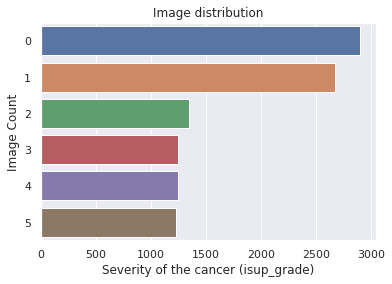

In [7]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
ax = sns.countplot(y = train_df['isup_grade'])
plt.title("Image distribution")
plt.xlabel('Severity of the cancer (isup_grade)')
plt.ylabel('Image Count')
plt.show()

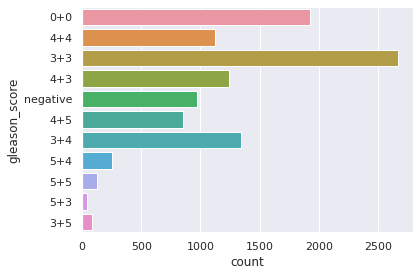

In [8]:
sns.countplot(y = train_df["gleason_score"])
plt.tight_layout()
plt.show()

Test and sample submission csv files have only 3 rows (samples).

In train data there is a column (gleason_score) that is not present either in test (with image_id & data_provider) or in sample submission (image_id & isup_grade) csv.

The objective is to predict isup_grade for each image in test set.

Let's check now the train data in train_images and train_label masks folders.

In [9]:
train_image_list = os.listdir(os.path.join(PATH, 'train_images'))
train_label_masks_list = os.listdir(os.path.join(PATH, 'train_label_masks'))

In [10]:
print(f"train image_id list: {train_df.image_id.nunique()}")
print(f"train image list: {len(train_image_list)}")
print(f"train label masks list: {len(train_label_masks_list)}")

train image_id list: 10616
train image list: 10616
train label masks list: 10516


We can observe that there are totally 10616 train images, with same number 10616 corresponding images and only 10516 mask images.

Consequently there are 100 images with missing masks.

In [11]:
print(f"sample of image_id list: {train_df.image_id.values[0:3]}")
print(f"sample of image list: {train_image_list[0:3]}")
print(f"sample of label masks list: {train_label_masks_list[0:3]}")

sample of image_id list: ['0005f7aaab2800f6170c399693a96917' '000920ad0b612851f8e01bcc880d9b3d'
 '0018ae58b01bdadc8e347995b69f99aa']
sample of image list: ['a05ded7fe107cfdfcfc8f644fb2d7313.tiff', '72e64850d127c65815492af84473a26e.tiff', '274187a867ebf7834ab44372da776439.tiff']
sample of label masks list: ['aa7000449538fe951e1c0dadc7ce9b44_mask.tiff', 'd63c41a88f43f4f46b49fe4d63c9d117_mask.tiff', 'b083e93e44742431259b7bf6f4df2000_mask.tiff']


### Some Examples of images

/opt/conda/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


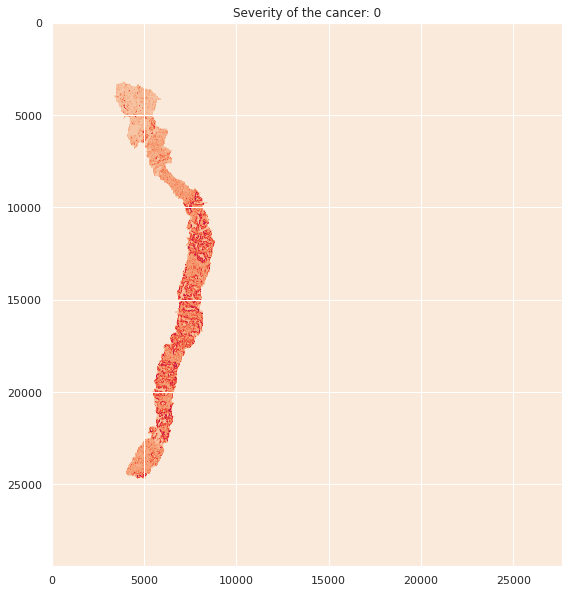

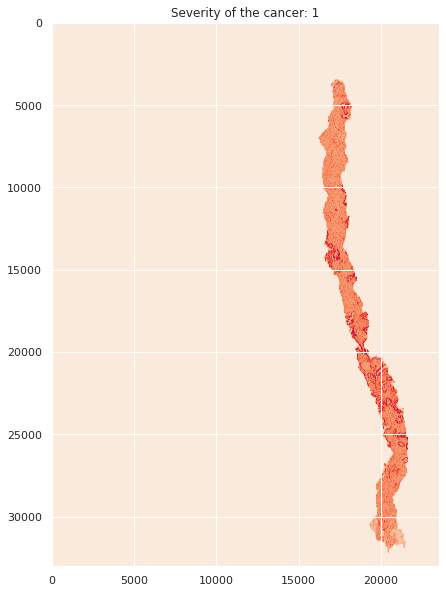

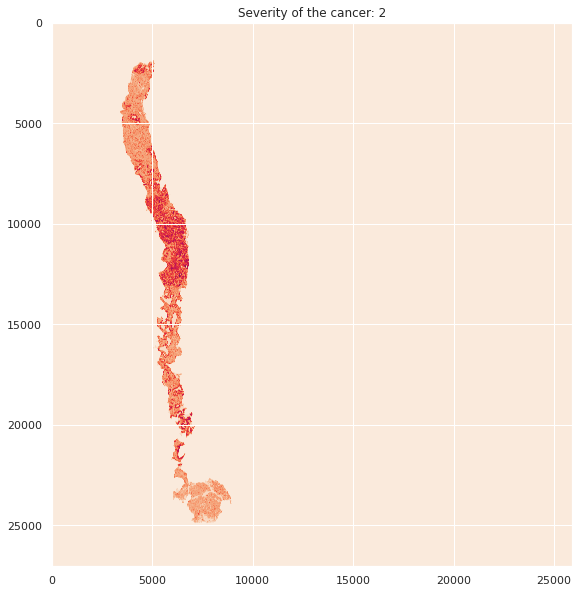

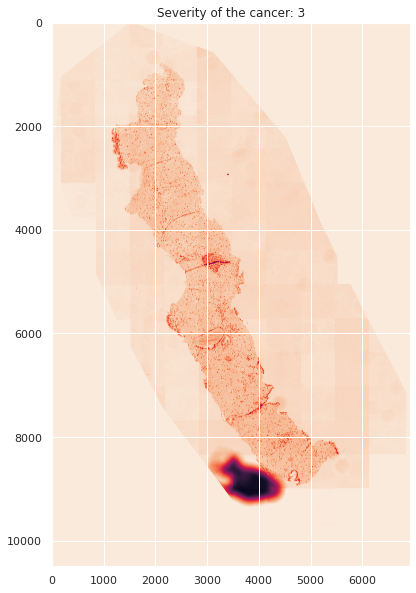

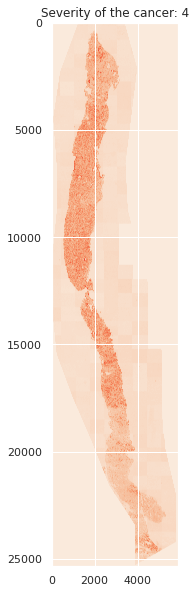

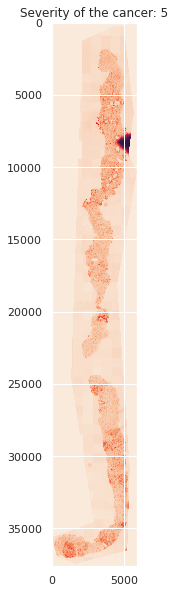

In [12]:
path = '/kaggle/input/prostate-cancer-grade-assessment/train_images/'
fg = [0, 6, 46, 15, 2 ,32]
for i in range(len(fg)):
    a = path +train_df['image_id'][fg[i]]+'.tiff'
    src = rasterio.open(a)
    array = src.read(1)
    from matplotlib import pyplot
    plt.figure(figsize= [10,10])
    #plt.subplot(221)
    plt.title('Severity of the cancer: '+str(train_df['isup_grade'][fg[i]]) )
    pyplot.imshow(array)
    pyplot.show()

## Masks of one of the above image

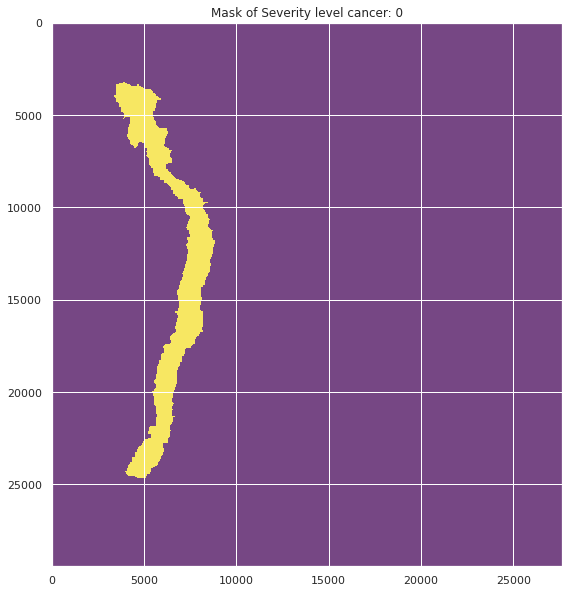

In [13]:
mask_path = '/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/'
fg = [0, 6, 46, 15, 2 ,32]
i = 0
a = mask_path +train_df['image_id'][fg[i]]+'_mask.tiff'
src = rasterio.open(a)
array = src.read(1)
from matplotlib import pyplot
plt.figure(figsize= [10,10])
#plt.subplot(221)
plt.title('Mask of Severity level cancer: '+str(train_df['isup_grade'][fg[i]]) )
pyplot.imshow(array, cmap=plt.cm.viridis, interpolation='none', alpha = 0.7)
pyplot.show()

## Mask over images

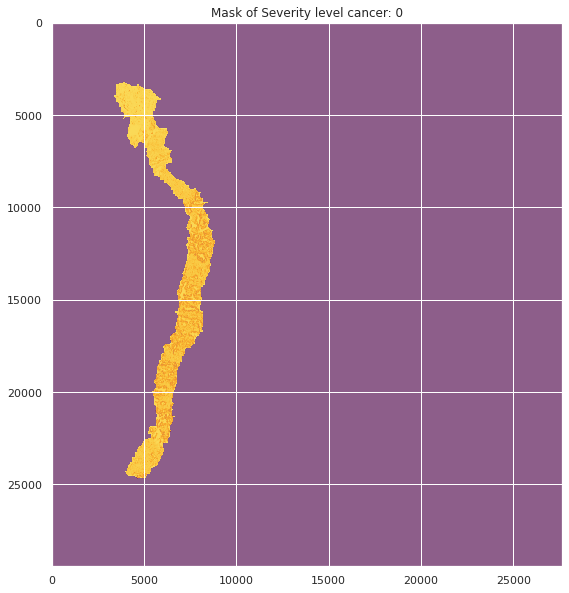

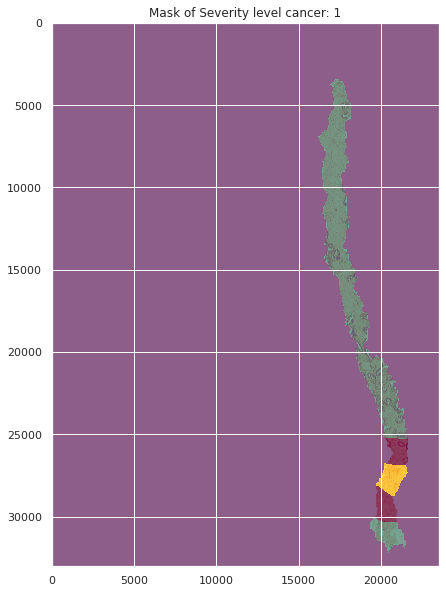

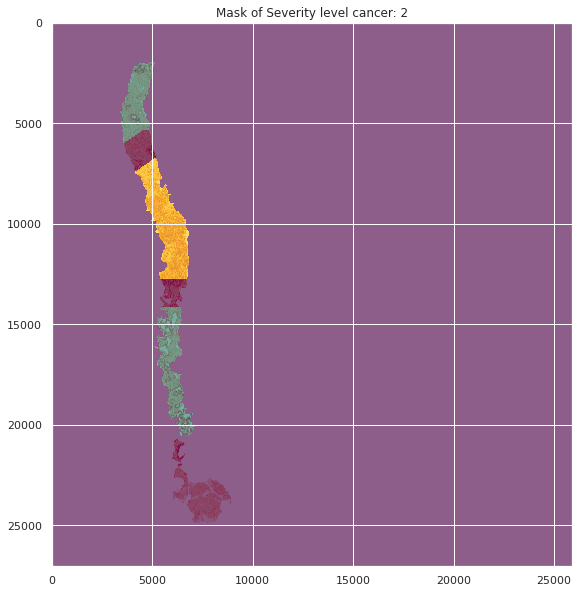

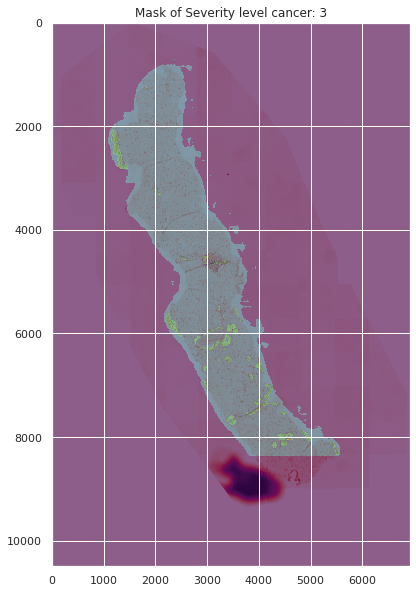

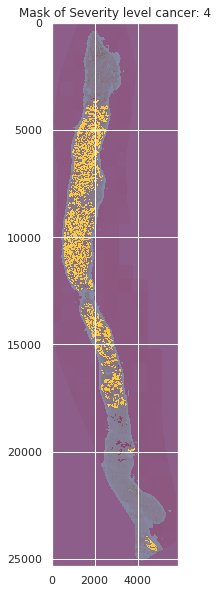

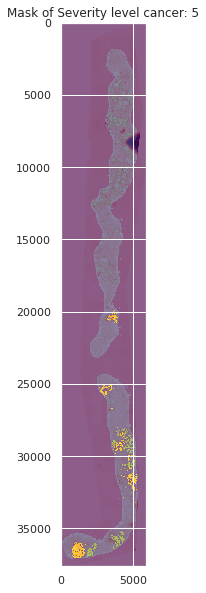

In [14]:
from matplotlib import pyplot
mask_path = '/kaggle/input/prostate-cancer-grade-assessment/train_label_masks/'
path = '/kaggle/input/prostate-cancer-grade-assessment/train_images/'
fg = [0, 6, 46, 15, 2 ,32]
for i in range(len(fg)):
    am = mask_path +train_df['image_id'][fg[i]]+'_mask.tiff'
    srcm = rasterio.open(am)
    arraym = srcm.read(1)
    plt.figure(figsize= [10,10])
    
    
    
    
    
    a = path +train_df['image_id'][fg[i]]+'.tiff'
    src = rasterio.open(a)
    array = src.read(1)
    plt.title('Mask of Severity level cancer: '+str(train_df['isup_grade'][fg[i]]) )
    pyplot.imshow(array)
    pyplot.imshow(arraym, cmap=plt.cm.viridis, interpolation='none', alpha = 0.6)
    
    pyplot.show()

### 3.Missing Data

Let's check for missing values in these lists.

For this, we will remove the suffix and extension from label masks and will remove the extension from image list.

In [15]:
trimmed_image_list = []
for img in train_image_list:
    trimmed_image_list.append(img.split('.tiff')[0])

In [16]:
trimmed_label_masks_list = []
for img in train_label_masks_list:
    trimmed_label_masks_list.append(img.split('_mask.tiff')[0])

In [17]:
intersect_i_m = (set(trimmed_image_list) & set(trimmed_label_masks_list))
intersect_id_m = (set(train_df.image_id.unique()) & set(trimmed_label_masks_list))
intersect_id_i = (set(train_df.image_id.unique()) & set(trimmed_image_list))

print(f"image (tiff) & label masks: {len(intersect_i_m)}")
print(f"image_id (train) & label masks: {len(intersect_id_m)}")
print(f"image_id (train) & image (tiff): {len(intersect_id_i)}")

image (tiff) & label masks: 10516
image_id (train) & label masks: 10516
image_id (train) & image (tiff): 10616


Both intersections with masks set cardinality is equal with the mask set data dimmensions. And intersection between train image ids and image equals train cardinality.

That means that, besides the missing 100 mask images, is no missing data: all images indexed in train data has corresponding tiff images and only 100 tiff label masks are missing.

Let's see what images have missing masks.

In [18]:
missing_masks  = np.setdiff1d(trimmed_image_list,trimmed_label_masks_list)
print(f'missing masks: {len(missing_masks)} images (press output button to see the list)')

missing masks: 100 images (press output button to see the list)


In [19]:
print(list(missing_masks))

['040b2c98538ec7ead1cbd6daacdb3f64', '05f2ae45ead3e5737d102656366752df', '0cbadddd6fd3eca47c33e48752f680cd', '0ebea13245a2b04ca3e6a482091e35d6', '11641ccf5569bc94de323bb50b7fec7e', '13ab419e772cf0dd8140f34f905bd918', '13aba34105b637fcf77e4efdc4ccaef4', '148b753bb4a61f27bc4f17c6d123e1ec', '1563523865810e5763f7f1dd1a30da85', '1a14633255dc8b2dd5a36fd6f3eaf839', '1aff7ddcd1864b0e2fa4fdf61e965a83', '2ac36a2e35654c0be9e818f9f9407807', '2d7eef10a777361cd0872f70dda344ba', '2f178956e9fc7df485c50395b9664b40', '31fd11d1920dede9f0fa0dcb35baa34e', '33105f777ddf03e095ed3350179b41da', '34b9896eebff5d0501dc23156b26f2b3', '3756141b86ca5f2afcacf5113d4e8f83', '3ac1b4146a8bea81e2ff2b1f2c0bb0c8', '3ae66332c2dd50c6ce458937d49f8232', '3ec8cdd4bcb971eea9c54d7dd1a49e1c', '41bfc11a16555808e8ddf2af836e6943', '458b3e1c2f1f56179d89fec4d56bd8d6', '4da79675b490fd611075cd6b84b83adb', '4e3f861386c391790eea8f0de4ab5015', '5037b3b05aec2c96a034ce9301a43326', '53f2d7fc3b642a8b6cc2d2780f6bb48b', '5477d1fe122c0b899b4be1634d

### 4.Data Exploration

Let's check distribution of data_provider, isup_grade and gleason_score in train data.

In [20]:
def plot_count(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(3*size,2*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set3')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

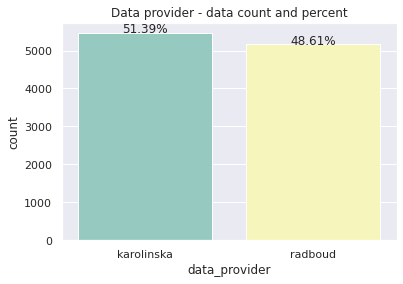

In [21]:
plot_count(train_df, 'data_provider', 'Data provider - data count and percent')

Two research sources are present: Karolinska Institute and Radboud University.

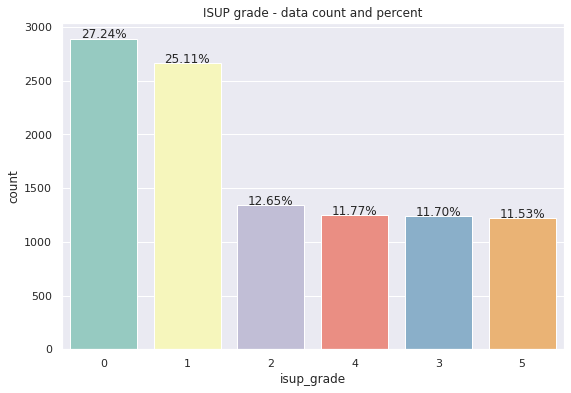

In [22]:
plot_count(train_df, 'isup_grade','ISUP grade - data count and percent', size=3)

In 2012, the International Society of Urologic Pathologists (ISUP) proposed a novel, validated grading system for clear cell renal cell carcinoma (ccRCC) and papillary renal cell carcinoma (pRCC) that has been implemented by the World Health Organization (WHO).This system is based primarily on the nucleoli assessment of the tumors, as follows [1]:

*     Grade 1: Inconspicuous nucleoli at ×400 magnification and basophilic
*     Grade 2: Clearly visible nucleoli at ×400 magnification and eosinophilic
*     Grade 3: Clearly visible nucleoli at ×100 magnification
*     Grade 4: Extreme pleomorphism or rhabdoid and/or sarcomatoid morphology

Majority of data samples in train set have ISUP grade values 0 or 1 (total > 50%) and the rest of the data samples have associated ISUP grades from 2 to 5 with all ranging in the 11-12% each.

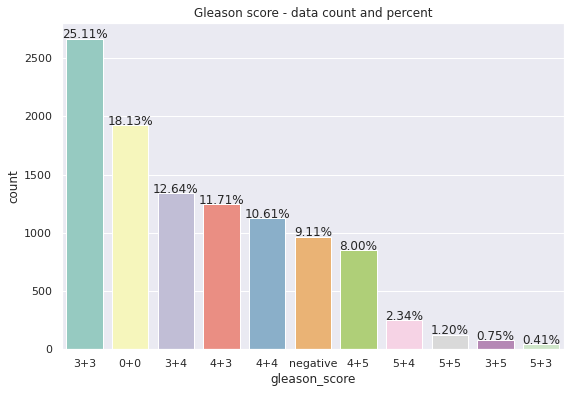

In [23]:
plot_count(train_df, 'gleason_score', 'Gleason score - data count and percent', size=3)

The data is unbalanced with respect of Gleason score values distribution.

Let's check now relative distribution of ISUP grade anf Gleason score values.

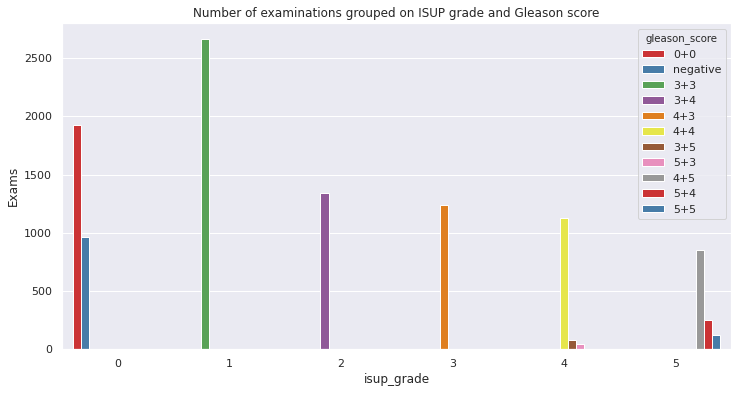

In [24]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6))
tmp = train_df.groupby('isup_grade')['gleason_score'].value_counts()
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index()
sns.barplot(ax=ax,x = 'isup_grade', y='Exams',hue='gleason_score',data=df, palette='Set1')
plt.title("Number of examinations grouped on ISUP grade and Gleason score")
plt.show()

### Inference:

*     All exams with ISUP grade = 0 have Gleason score 0+0 or negative.
*     All exams with ISUP grade = 1 have Gleason score 3+3.
*     All exams with ISUP grade = 2 have Gleason score 3+4.
*     All exams with ISUP grade = 3 have Gleason score 4+3.
*     All exams with ISUP grade = 4 have Gleason score 4+4 (majority), 3+5 or 5+3.
*     All exams with ISUP grade = 5 have Gleason score 4+5 (majority), 5+4 or 5+5.

#### This data distribution can be better visualized using a heatmap as below:

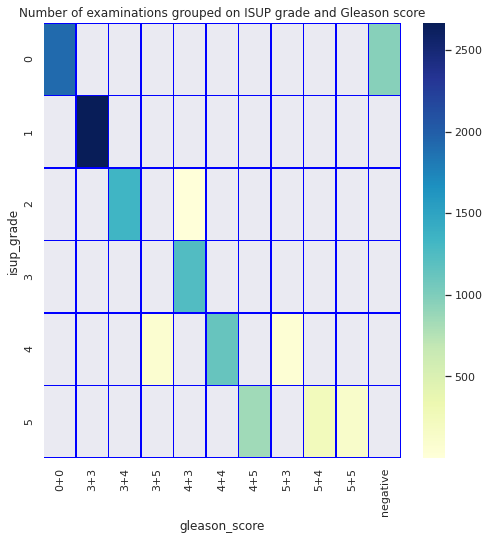

In [25]:
fig, ax = plt.subplots(nrows=1,figsize=(8,8))
heatmap_data = pd.pivot_table(df, values='Exams', index=['isup_grade'], columns='gleason_score')
sns.heatmap(heatmap_data, cmap="YlGnBu",linewidth=0.5, linecolor='blue')
plt.title('Number of examinations grouped on ISUP grade and Gleason score')
plt.show()

#### This seems to be aligned with the correspondence matrix as shown in the following table:

In [26]:
from IPython.display import HTML, display

data = [["Gleason Score", "ISUP Grade"],
        ["0+0", "0"], ["negative", "0"],
        ["3+3", "1"], ["3+4", "2"], ["4+3", "3"], 
        ["4+4", "4"], ["3+5", "4"], ["5+3", "4"],
        ["4+5", "5"], ["5+4", "5"], ["5+5", "5"],
        ]

display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
       )
))

Gleason Score,ISUP Grade
0+0,0
negative,0
3+3,1
3+4,2
4+3,3
4+4,4
3+5,4
5+3,4
4+5,5
5+4,5


The only misalignment is in the fact that for ISUP Grade 2, in the data we also have Gleason score 4+3 (which also appears for ISUP Grade 3).

Let's see how Gleason score is grouped by Data source.


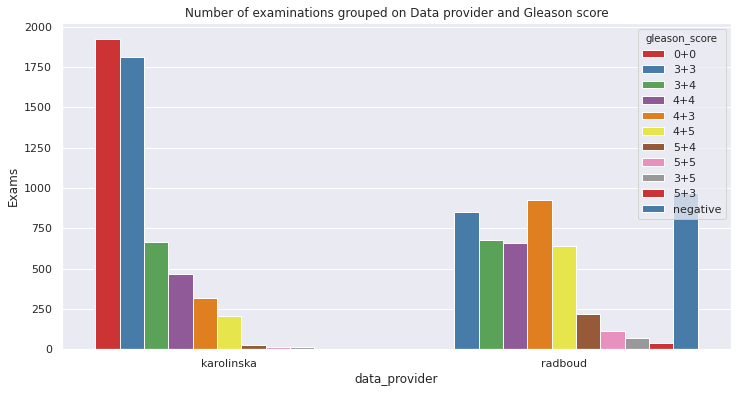

In [27]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('data_provider')['gleason_score'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='gleason_score',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Data provider and Gleason score") 
plt.show()

We can observe that all of the 0+0 Gleason score data samples are from Karolinska while from Radboud we have most of negative data.

For Karolinska, next (in terms of frequency) are samples with Gleason score 3+3, 3+4, 4+4.

For Radboud, next (in terms of frequency) most frequent are samples with Gleason score 4+3, 3+3, 3+4, 4+4, 4+5.

Let's see how ISUP grade is distributed with respect of Data provider.

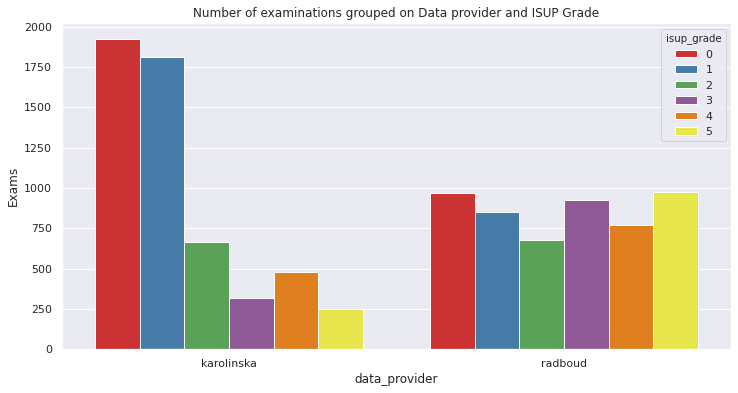

In [28]:
fig, ax = plt.subplots(nrows=1,figsize=(12,6)) 
tmp = train_df.groupby('data_provider')['isup_grade'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='isup_grade',data=df, palette='Set1') 
plt.title("Number of examinations grouped on Data provider and ISUP Grade") 
plt.show()

Most of the 0 & 1 ISUP Grade samples are originated from Karolinska.

Most of the 2-5 ISUP Grade samples are originated from Radboud.